In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from modules import *
from models import *
from torchvision import datasets, transforms

In [2]:
torch.cuda.empty_cache()

In [3]:
train_data = datasets.MNIST(root='/Users/Linsu Han/Documents/datasets/mnist/train.pt', train=True, download=True, transform=transforms.ToTensor())
val_data = datasets.MNIST(root='/Users/Linsu Han/Documents/datasets/mnist/val.pt', train=False, download=True, transform=transforms.ToTensor())

In [4]:
in_distribution = {0, 1, 2, 3, 4}
train_subset = get_subset(train_data, in_distribution)

In [5]:
print('train_data', len(train_data))
print('train_subset', len(train_subset))
print('val_data', len(val_data))

train_data 60000
train_subset 30596
val_data 10000


# Conv2d

`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`

$$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) + \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$

$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
$$

$$
W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$$

# MaxPool2d

`nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)`

$$
H_{out} = \left\lfloor\frac{H_{in} + 2 * \text{padding[0]} - \text{dilation[0]} \times (\text{kernel\_size[0]} - 1) - 1}{\text{stride[0]}} + 1\right\rfloor
$$

$$
W_{out} = \left\lfloor\frac{W_{in} + 2 * \text{padding[1]} - \text{dilation[1]} \times (\text{kernel\_size[1]} - 1) - 1}{\text{stride[1]}} + 1\right\rfloor
$$

# ConvTranspose2d
`nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')`

$$
              H_{out} = (H_{in} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1
$$

$$
              W_{out} = (W_{in} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1
$$

In [6]:
# Defaults
# nn.Sequential(*args)
# nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
# nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
# nn.Linear(in_features, out_features, bias=True)
# nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

In [7]:
# Using stride=1
dim = 28
dim = conv_dim(dim, 5, 1, 0, 1)
dim = conv_dim(dim, 3, 1, 0, 1)
dim = conv_dim(dim, 3, 1, 0, 1)
dim = deconv_dim(dim, 3, 1, 0, 0, 1)
dim = deconv_dim(dim, 3, 1, 0, 0, 1)
dim = deconv_dim(dim, 5, 1, 0, 0, 1)

Output: 24
Output: 22
Output: 20
Output: 22
Output: 24
Output: 28


`f(x) = floor[ (x + 2*padding1 - kernel1) / stride1 + 1]`

`g(x) = (x - 1)*stride2 - 2*padding2 + kernel2`

Given `stride1, stride2 > 1`, is it possible to have parameters s.t. `g(f(x)) = x` for all `x`?

=> Yes iff `x + 2*padding1 - kernel1` is divisible by `stride1`

Try:

let `padding1 = 0`

need to find `kernel1` s.t. `(x-kernel1) % stride1 == 0` for all `x`

We can control `kernel1` s.t. numerator is even so it works for `stride1 = 2`


In [8]:
# Using stride=2

dim = 28

def get_kernel(dim):
    if dim%2==0: # even input
        return 4 # subtract by even
    else: # odd input
        return 3 # subtract by odd

k1 = get_kernel(dim)
dim = conv_dim(dim, k1, 2, 0, 1)
k2 = get_kernel(dim)
dim = conv_dim(dim, k2, 2, 0, 1)
k3 = get_kernel(dim)
dim = conv_dim(dim, k3, 2, 0, 1)
dim = deconv_dim(dim, k3, 2, 0, 0, 1)
dim = deconv_dim(dim, k2, 2, 0, 0, 1)
dim = deconv_dim(dim, k1, 2, 0, 0, 1)

Output: 13
Output: 6
Output: 2
Output: 6
Output: 13
Output: 28


In [9]:
nn_module = ConvAutoencoder(16, *train_data[0][0].shape)
model = CAEModel(nn_module)

In [10]:
model.train(train_subset, 16, verbose=True, batch_size=32, num_workers=2, shuffle=True)
model.save('./mnist_cae.pth')

  6%|█████▏                                                                             | 1/16 [00:05<01:26,  5.80s/it]

0.021005072865475555


 12%|██████████▍                                                                        | 2/16 [00:10<01:12,  5.18s/it]

0.011284878400573848


 19%|███████████████▌                                                                   | 3/16 [00:15<01:04,  4.98s/it]

0.009669262404936048


 25%|████████████████████▊                                                              | 4/16 [00:20<00:58,  4.88s/it]

0.008828211028825651


 31%|█████████████████████████▉                                                         | 5/16 [00:24<00:53,  4.83s/it]

0.00832557762353102


 38%|███████████████████████████████▏                                                   | 6/16 [00:29<00:48,  4.81s/it]

0.007967838007361163


 44%|████████████████████████████████████▎                                              | 7/16 [00:34<00:43,  4.79s/it]

0.007699350176852045


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:39<00:38,  4.78s/it]

0.007472002529904106


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:43<00:33,  4.77s/it]

0.007292924560762187


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:48<00:28,  4.77s/it]

0.007128587351234138


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:53<00:23,  4.78s/it]

0.007013211970274943


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:58<00:19,  4.78s/it]

0.00689775906863273


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [01:02<00:14,  4.77s/it]

0.006799122810075712


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [01:07<00:09,  4.76s/it]

0.00670246054032037


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [01:12<00:04,  4.77s/it]

0.006606308449947255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:17<00:00,  4.82s/it]

0.006551053452859229


In [11]:
# model.load('./mnist_cae.pth')

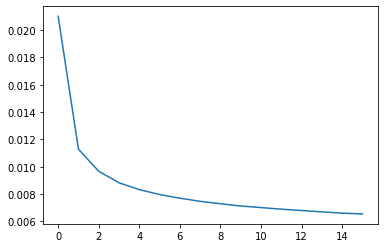

In [12]:
plt.plot(model.losses_epoch)

In [13]:
outputs = model.evaluate([val_data])

In [14]:
mse_dict = {k:[d['mse'] for d in v] for k, v in outputs.items()}

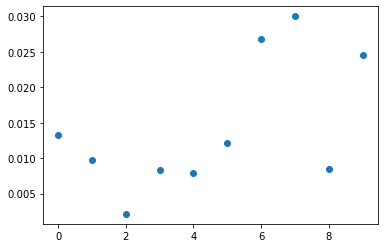

In [15]:
plt.scatter(range(10), [sum(v)/len(v) for v in mse_dict.values()])

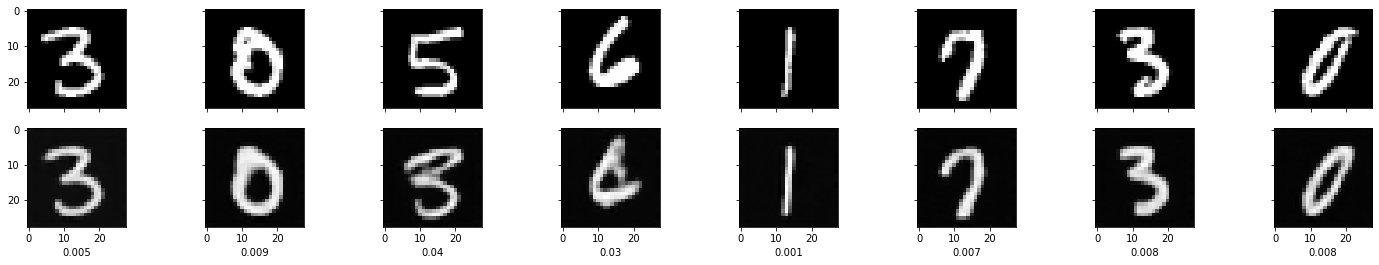

In [16]:
model.visualize(val_data, 8)

In [17]:
thresholds = np.arange(1e-3, 50e-3, 1e-3)
tpr, tnr = get_acc(mse_dict, thresholds, in_distribution)

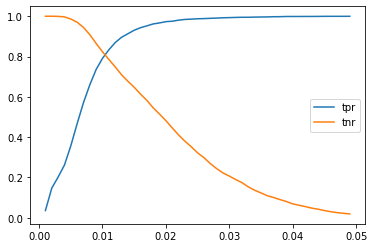

In [18]:
plt.plot(thresholds, tpr)
plt.plot(thresholds, tnr)
plt.legend(('tpr', 'tnr'))

Text(0, 0.5, 'True Positive Rate')

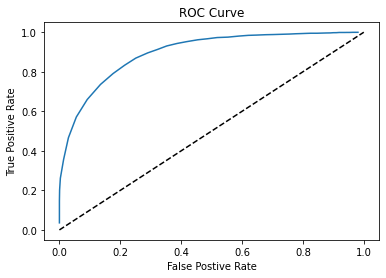

In [19]:
plt.plot(1-np.array(tnr), tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')